# Introduction to ReLM

ReLM is a <u>r</u>egular <u>e</u>xpression (regex) search engine for <u>l</u>anguage <u>m</u>odels (LMs).
At a high level, a user inputs a query to ReLM in the form of a [regular expression](https://en.wikipedia.org/wiki/Regular_expression), the regular expression is compiled to a representation of the space of matching strings, and the ReLM engine executes the language model over that space.

One area that ReLM can be applied to is _model validation_, the act of ensuring that a model conforms to specifications of correctness.
For example, it is clear that a language model should be accurate in its predictions, but it may also be desirable for it to _not_ have other properties, such as the ability to generate biased, toxic, or memorized text.
Such testing is specifically useful for autoregressive large language models (LLMs), which consume and produce _arbitrary strings_, and thus have more degrees of freedom than traditional machine learning models.

##  Model Loading

To start, let's load the XL variant of [GPT-2](https://openai.com/research/better-language-models) model using Hugging Face Transformers.
Note that you can use a smaller model (e.g., "gpt2") if you need to (e.g., limited GPU memory), though some of this notebook's commentary will make less sense.

At this point, we're just loading a model and its tokenizer, and ReLM is not yet needed.
If you need more information on [PyTorch](https://pytorch.org/) or Hugging Face [Transformers](https://huggingface.co/docs/transformers/index), you can check out their tutorials
[\[1\]](https://pytorch.org/tutorials/)
[\[2\]](https://huggingface.co/docs/transformers/quicktour).

In [1]:
import torch
torch.manual_seed(42)

from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2-xl"  # Change this to "gpt2" if you get memory issues

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             return_dict_in_generate=True,
                                             pad_token_id=tokenizer.eos_token_id).to(device)

## A Validation Warmup

Let's now pretend we are testing the model.
We want to answer the question: "Does the model know the birthdate of George Washington?".
One way to do this test is to sample from the model given the prefix, and see what happens.
You can see that we can't glean much from this information---some of the responses aren't even dates, and they have all this extra stuff at the end.
We can see some patterns in the data (e.g., date ranges and sentence structure) which may allow us to be more or less confident that the model knows _something_.

However, analyzing the entire distribution seems ***hard*** because we don't even have a consistent format of the 
date (e.g., "May 10, 1732" vs. "this day in 1732").
The phrase "this day in 1732" is technically correct one day of the year, but that sort of answer is not something we _want_ to evaluate.
Can we test the set of responses in a way where the output _is_ structured (i.e., where we know we will get a date for sure)? 🤔

In [2]:
# Create a prefix/prompt
prefix = "George Washington was born on"
# Convert it to tokens. We add BOS token (as mirrored below).
input_ids = torch.tensor([tokenizer.bos_token_id,] + tokenizer.encode(prefix)).reshape(1, -1).to(device)
# Generate responses from the model (in tokens)
tokens = model.generate(input_ids,
                        max_new_tokens=20,
                        num_return_sequences=10,
                        do_sample=True).sequences
# Print the strings representing the responses
for t in tokens:
    print(tokenizer.decode(t[1:]))

George Washington was born on May 10, 1732 and died on March 4, 1799. George Washington became president under the
George Washington was born on the day Abraham Lincoln would have been buried.[1] It was in 1799 and the US was
George Washington was born on August 21, 1732 in New Kent, New York to David and Mary Washington — a slave woman
George Washington was born on January 22, 1732 in Williamsburg, Virginia. He and his brother, Thomas, who died
George Washington was born on this day in 1732. He became one of the greatest U.S. leaders of all time
George Washington was born on October 8, 1732, the second of five children who died shortly after his birth. Washington had
George Washington was born on April 19, 1732, in Williamsburg, Virginia. His family joined the British colony of Virginia
George Washington was born on November 19, 1732. He died on January 21, 1799 and was buried in Arlington National
George Washington was born on November 13, 1732 during an important time in American hi

##  Continuing Validation with ReLM

To demonstrate ReLM, let's do a simple knowledge verification query of the model, building off the prior example.
Specifically, let's test for George Washington's birthday.
One way to do this is to ask "George Washington was born on <u>date</u>".
Let's construct the query in ReLM.

### Query Construction

Below, we construct a regular expression query using ReLM's abstractions.
To start, we have to define what strings we are looking for, using a `relm.QueryString`.
The first parameter, `query_str`, defines exactly what strings we are looking for.
In regular expression syntax, we are saying "George Washington was born on <u>date</u>", where "<u>date</u>" is a month, day, and year.
Notice we also fill in the `prefix_str` parameter.
`prefix_str` is a substring of `query_str`, and it indicates that the user wants that prefix to be treated as if it were fixed.
If you are familiar with [prompting](https://en.wikipedia.org/wiki/Prompt_engineering), the `prefix_str` parameter is trying to capture the prompt.
Importantly, since the `prefix_str` is treated as fixed, ReLM always traverses these prefixes, even if they would otherwise be rejected due to other query constraints.
While `query_str` is in some sense a _rejection_ of strings a user is interested in (i.e., reject all strings that don't match the regular expression pattern), the `prefix_str` is in a similar sense an unconditional _acceptance_ of strings a user is interested in.

In [3]:
import relm
query_string = relm.QueryString(query_str=("George Washington was born on "
                                           "((January)|(February)|(March)|(April)|"
                                           "(May)|(June)|(July)|(August)|(September)|"
                                           "(October)|(November)|(December)) "
                                           "[0-9]{1,2}, [0-9]{4}"),
                                prefix_str="George Washington was born on"
                               )

Now, we need to _execute_ the query.
To do so, ReLM needs some additional information, which is specified to the `relm.SimpleSearchQuery` object.
Namely, we specify:
1. What strings are we interested in?
2. What is the traversal order over the space of strings?
3. What type of tokenizations of the strings do we want to explore?
4. What application-specific parameters do we have?

To start, notice we set `top_k` to `None`.
_top-k_ is used to reject sequences which are very unlikely compared to alternatives.
By setting it to `None`, we are saying that we don't want to apply this option.
Some applications use this parameter, so it is important to address it.
We could have alternatively set `top_k = 40`, which is a common value for the parameter.
In that case, `prefix_str` would have been important to not reject strings starting with "George Washington" in case the tokens for "George Washington" were not all in the top 40 tokens.

Now, we begin by constructing the `relm.SimpleSearchQuery` object.
First, notice we pass our `relm.QueryString` object to the `query_string` parameter to specify the strings we are interested in.
Second, we say that the `search_strategy` is a `relm.QuerySearchStrategy.SHORTEST_PATH`, which means our traversal order finds the most likely strings first.
Alternatively, we could have set this parameter to `relm.QuerySearchStrategy.RANDOM_SAMPLING`, to sample from the set of strings.
Third, we specify that the `tokenization_strategy` is a `relm.QueryTokenizationStrategy.ALL_TOKENS`, which means we are interested in all tokenizations of the strings.
If we wanted to only use the most compact representation of a string (i.e., what a tokenization encoder would return for that string), we would pass `relm.QueryTokenizationStrategy.CANONICAL_TOKENS`.
Fourth, we set the `top_k_sampling` to our `top_k` parameter and set `sequence_length=None` to indicate that for our application, we want to not use `top_k` and our sequences are unlimited in terms of the number of tokens, barring limitations of the model.

In [4]:
top_k = None
query = relm.SimpleSearchQuery(query_string=query_string,
                               search_strategy=relm.QuerySearchStrategy.SHORTEST_PATH,
                               tokenization_strategy=relm.QueryTokenizationStrategy.ALL_TOKENS,
                               top_k_sampling=top_k,
                               sequence_length=None,
                              )

### Search Construction

Now that we have the `query` object, we need to do something with it to get results.
To do so, we launch a `relm.search` procedure, which binds the `model` and `tokenizer` to the `query`.
In return, we get an [iterator](https://wiki.python.org/moin/Iterator) over the solution space.
The iterator, `ret_iter`, will return tokens—the model-specific integers representing the strings—that match our query.
Note that search construction will build internal-specific data structures for ReLM, and thus may take a moment to complete.

In [5]:
ret_iter = relm.search(model, tokenizer, query)

## Sampling

We can now launch the query.
We'll create a helper function `process_relm_iterator` for processing the iterator.
By default, the iterator may return much more strings that we are willing to inspect.
For this demo, we truncate the iterator after the first `num_samples=100` samples by setting `itertools.islice(ret_iter, num_samples)`.

ReLM comes with some utilities to help us with common tasks, such as predicting the probability of a token sequence.
To use these, we need to wrap the model and tokenizer in a model wrapper that ReLM interacts with, a `relm.model_wrapper.TestableModel`.
This wrapper is essentially a translation layer between the model + tokenizer and the ReLM backend.

In the loop, we return the tuples of tokens that match on the query in the variable `x`.
We then add the Beginning of Sequence (BOS) Token back to `x`, since it is used internally as a prefix to the query.
We can evaluate the probability of the tokens in `x` by iteratively computing the probability of each token, and we store that value in `p`.
Since `p` represents length $n$ vector of probabilities (one for each token), where $n$ is the sequence length, we can calculate the total probability $\prod_{i=1}^n p_i$ of the sequence.
We can also compute the conditional probability $\prod_{i=j}^n p_i$ for the suffix, where the suffix starts at token $j$.
Finally, we convert the sequence `x` to a string `match_string`.

In [6]:
import numpy as np
import itertools

def end_of_prefix_idx(test_relm, prefix, tokens):
    """Find first index where tokens are not in prefix."""
    i = 0
    curr_str = ""
    stack = list(reversed(tokens))
    while not curr_str.startswith(prefix):
        curr = stack[-1]
        stack.pop(-1)
        s = test_relm.tokens_to_words([curr])
        curr_str += s
        i += 1
    return i

def process_relm_iterator(ret_iter, num_samples=100):
    """Retrieve num_samples items and return processed data."""
    test_relm = relm.model_wrapper.TestableModel(model, tokenizer)

    xs = []
    matches = []
    probs = []
    conditional_probs = []
    for x in itertools.islice(ret_iter, num_samples):
        x = (tokenizer.bos_token_id,) + x  # Add BOS back
        p = test_relm.point_query_tokens(x, top_k=top_k)
        # Get (conditional) probability of non-prefix
        conditional_p_idx = end_of_prefix_idx(
            test_relm, query_string.prefix_str, x[1:])
        conditional_p = p[conditional_p_idx:]
        conditional_p = np.prod(conditional_p)
        p = np.prod(p)  # Get total prob
        match_string = test_relm.tokens_to_words(x)
        xs.append(x)
        matches.append(match_string)
        probs.append(p)
        conditional_probs.append(conditional_p)
        
    return xs, matches, probs, conditional_probs

xs, matches, probs, conditional_probs = process_relm_iterator(ret_iter)

0it [00:00, ?it/s]

For this query, let's see what the most likely matches are.

In [7]:
matches[:10]

['George Washington was born on July 4, 1732',
 'George Washington was born on November 22, 1732',
 'George Washington was born on December 22, 1732',
 'George Washington was born on January 22, 1732',
 'George Washington was born on January 20, 1732',
 'George Washington was born on February 22, 1732',
 'George Washington was born on April 30, 1732',
 'George Washington was born on April 22, 1732',
 'George Washington was born on September 22, 1732',
 'George Washington was born on December 25, 1732']

Hmm, the top answer is not what we wanted 🤔.
The expected [birthdate](https://en.wikipedia.org/wiki/George_Washington) is February 22, 1732.
However, we can see that the correct answer is 6th in this list, so the model is reasonably aware of the correct answer.
Unlike the opening example, we know for sure that we get a date in exactly the format we wanted.

In fact, let's check that all matches are valid matches according to the regular expression.
Just for fun, let's use the Python [re](https://docs.python.org/3/library/re.html) module.
Note that ReLM uses a different, internal regular-expression backend, so we should be careful that the syntax is the same.
However, in this case, the `query_str` means the same thing in both cases.

In [8]:
import re

prog = re.compile(query_string.query_str)
for match in matches:
    assert re.match(prog, match)

✅ Looks good.

Finally, let's see that the traversal order goes from most likely to least in terms of total probability.
If we were using random sampling, we wouldn't expect this to be the case.

Reference probability: 1.195227810057986e-06


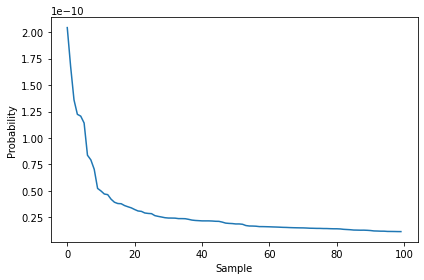

In [9]:
import matplotlib.pyplot as plt

# Calculate non-date conforming response as a baseline
ref_response = "George Washington was born on this day in 1732"
test_relm = relm.model_wrapper.TestableModel(model, tokenizer)
input_ids = torch.tensor([tokenizer.bos_token_id,] +
                         tokenizer.encode(ref_response)).reshape(1, -1).to(device)
ref_p = test_relm.point_query_tokens(input_ids, top_k=top_k)[1:]  # Don't include BOS prob
ref_p = np.prod(ref_p)  # Get total prob
print("Reference probability: {}".format(ref_p))

def plot_sample_probability(probs, show_ref_prob=False):
    """Show total probabilities of ReLM's outputs."""
    plt.plot(probs, label="ReLM Output")
    plt.ylabel("Probability")
    plt.xlabel("Sample")
    if show_ref_prob:
        plt.hlines(xmin=0, xmax=len(probs), y=ref_p, colors="r",
                   linestyles="dashed", label="Example Probability")
    plt.tight_layout()
    
plot_sample_probability(probs, show_ref_prob=False)

✅ We see the probability is decreasing over the samples, indicating responses are ordered by likelihood.
We also calculate a reference probability for "George Washington was born on this day in 1732".
We can see that the reference is actually _higher_ likelihood than the dates ReLM found—perhaps because the model doesn't have to commit to a particular date.

# Extra Queries

### Anything Goes and Free Response

Building on the introduction example, what if we didn't constrain ReLM to use a date?
`(( )|([a-zA-Z0-9])|(,))+` represents spaces, commas, and alphanumeric characters 1+ times.

In [10]:
query_string = relm.QueryString(query_str="George Washington was born on (( )|([a-zA-Z0-9])|(,))+",
                                prefix_str="George Washington was born on",
                               )
top_k = None
query = relm.SimpleSearchQuery(query_string=query_string,
                               search_strategy=relm.QuerySearchStrategy.SHORTEST_PATH,
                               tokenization_strategy=relm.QueryTokenizationStrategy.ALL_TOKENS,
                               top_k_sampling=top_k,
                               sequence_length=None,
                              )
ret_iter = relm.search(model, tokenizer, query)

xs, matches, probs, conditional_probs = process_relm_iterator(ret_iter, num_samples=20)
matches

0it [00:00, ?it/s]

['George Washington was born on this',
 'George Washington was born on December',
 'George Washington was born on this day',
 'George Washington was born on January',
 'George Washington was born on April',
 'George Washington was born on this day in',
 'George Washington was born on July',
 'George Washington was born on this day in 17',
 'George Washington was born on February',
 'George Washington was born on March',
 'George Washington was born on November',
 'George Washington was born on this day in 1732',
 'George Washington was born on the',
 'George Washington was born on May',
 'George Washington was born on June',
 'George Washington was born on September',
 'George Washington was born on October',
 'George Washington was born on July 4',
 'George Washington was born on August',
 'George Washington was born on July 4,']

Look at that: "George Washington was born on this day in 1732" appears again.
Random sampling sees it come up often because it's likely.
Notice that we have limited control over how complete a sentence may be, since our regular expression technically allows a sequence to be complete with only one character.

### Multiple Choice

We can also use ReLM to construct multiple choice queries. Here, we pick between the 4 dates: `((February 23, 1973)|(March 30, 1973)|(February 1, 1873)|(February 22, 1732))`.

In [11]:
query_string = relm.QueryString(query_str=("George Washington was born on ((February 23, 1973)|"
                                           "(March 30, 1973)|(February 1, 1873)|(February 22, 1732))"),
                                prefix_str="George Washington was born on",
                               )
top_k = None
query = relm.SimpleSearchQuery(query_string=query_string,
                               search_strategy=relm.QuerySearchStrategy.SHORTEST_PATH,
                               tokenization_strategy=relm.QueryTokenizationStrategy.ALL_TOKENS,
                               top_k_sampling=top_k,
                               sequence_length=None,
                              )
ret_iter = relm.search(model, tokenizer, query)

xs, matches, probs, conditional_probs = process_relm_iterator(ret_iter, num_samples=20)
matches

0it [00:00, ?it/s]

['George Washington was born on February 22, 1732',
 'George Washington was born on February 22, 1732',
 'George Washington was born on February 1, 1873',
 'George Washington was born on February 23, 1973',
 'George Washington was born on February 22, 1732',
 'George Washington was born on March 30, 1973',
 'George Washington was born on February 22, 1732',
 'George Washington was born on February 22, 1732',
 'George Washington was born on February 22, 1732',
 'George Washington was born on February 23, 1973',
 'George Washington was born on February 22, 1732',
 'George Washington was born on March 30, 1973',
 'George Washington was born on February 22, 1732',
 'George Washington was born on February 22, 1732',
 'George Washington was born on February 1, 1873',
 'George Washington was born on February 23, 1973',
 'George Washington was born on February 1, 1873',
 'George Washington was born on February 22, 1732',
 'George Washington was born on March 30, 1973',
 'George Washington was 

✅ Here, the model is able to guess the right answer.
But why are there duplicates? 🤔

Well, technically there aren't.
The token sequences are unique, but two sequences can map to the same string due to the way tokenization is performed.

In [12]:
list(zip(matches, xs))[:5]

[('George Washington was born on February 22, 1732',
  (50256, 20191, 2669, 373, 4642, 319, 3945, 2534, 11, 1596, 2624)),
 ('George Washington was born on February 22, 1732',
  (50256, 20191, 2669, 373, 4642, 319, 3158, 622, 560, 2534, 11, 1596, 2624)),
 ('George Washington was born on February 1, 1873',
  (50256, 10082, 3643, 2669, 373, 4642, 319, 3945, 352, 11, 1248, 4790)),
 ('George Washington was born on February 23, 1973',
  (50256, 10082, 3643, 2669, 373, 4642, 319, 3945, 2242, 11, 15674)),
 ('George Washington was born on February 22, 1732',
  (50256, 20191, 2669, 373, 4642, 319, 3158, 81, 2838, 2534, 11, 1596, 2624))]

Let's remove the duplicates by enforcing the tokenization is canonical, which requires each string to have a unique encoding.
Notice that `tokenization_strategy=relm.QueryTokenizationStrategy.CANONICAL_TOKENS`.

In [13]:
query_string = relm.QueryString(query_str=("George Washington was born on ((February 23, 1973)|"
                                           "(March 30, 1973)|(February 1, 1873)|(February 22, 1732))"),
                                prefix_str="George Washington was born on",
                               )
top_k = None
query = relm.SimpleSearchQuery(query_string=query_string,
                               search_strategy=relm.QuerySearchStrategy.SHORTEST_PATH,
                               tokenization_strategy=relm.QueryTokenizationStrategy.CANONICAL_TOKENS,
                               top_k_sampling=top_k,
                               sequence_length=None,
                              )
ret_iter = relm.search(model, tokenizer, query)

xs, matches, probs, conditional_probs = process_relm_iterator(ret_iter, num_samples=20)
matches

0it [00:00, ?it/s]

['George Washington was born on February 22, 1732',
 'George Washington was born on March 30, 1973',
 'George Washington was born on February 23, 1973',
 'George Washington was born on February 1, 1873']

In [14]:
len(set(xs)) == len(matches)

True

✅ We see that there are only 4 choices, as expected.
Furthermore, the right answer is at the top.

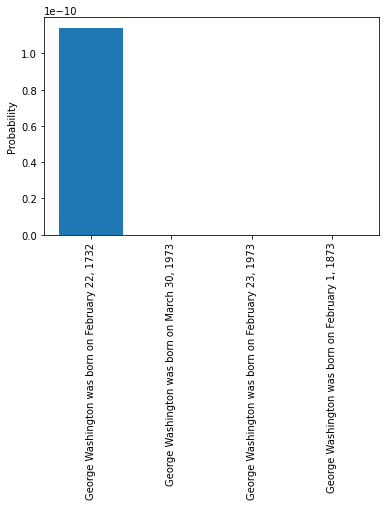

In [15]:
plt.bar(matches, probs)
plt.xticks(rotation=90)
_ = plt.ylabel("Probability")

Since 3 of the 4 bars are invisible, we can plot the negative log conditional probability to better distinguish the trends.
Here, lower is more likely.

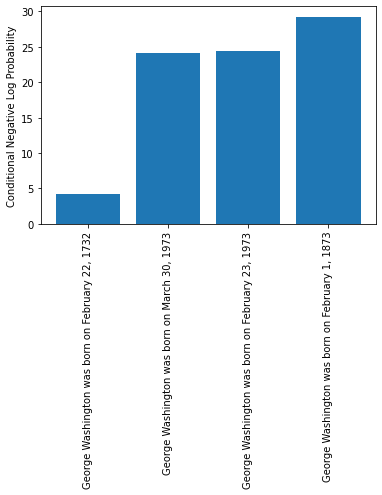

In [16]:
plt.bar(matches, -np.log(conditional_probs))
plt.xticks(rotation=90)
_ = plt.ylabel("Conditional Negative Log Probability")

😈 Any idea how we can make the model guess wrong?
Well, we already know that "George Washington was born on July 4, 1732" is a very likely answer, given the first ReLM query.
Let's add that in the answers to throw the model off.

In [17]:
query_string = relm.QueryString(query_str=("George Washington was born on ((July 4, 1732)|"
                                           "(March 30, 1973)|(February 1, 1873)|(February 22, 1732))"),
                                prefix_str="George Washington was born on",
                               )
top_k = None
query = relm.SimpleSearchQuery(query_string=query_string,
                               search_strategy=relm.QuerySearchStrategy.SHORTEST_PATH,
                               tokenization_strategy=relm.QueryTokenizationStrategy.CANONICAL_TOKENS,
                               top_k_sampling=top_k,
                               sequence_length=None,
                              )
ret_iter = relm.search(model, tokenizer, query)

xs, matches, probs, conditional_probs = process_relm_iterator(ret_iter, num_samples=20)
matches

0it [00:00, ?it/s]

['George Washington was born on July 4, 1732',
 'George Washington was born on February 22, 1732',
 'George Washington was born on March 30, 1973',
 'George Washington was born on February 1, 1873']

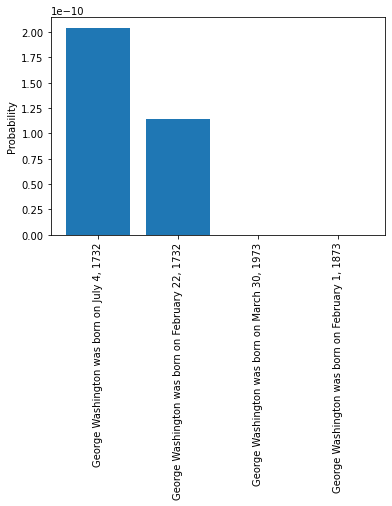

In [18]:
plt.bar(matches, probs)
plt.xticks(rotation=90)
_ = plt.ylabel("Probability")

😎 As expected, we can always be an adversary with access to a model's predictions outside the multiple choice set.
We can always take the most likely incorrect answer and use it to "poison" the multiple choice set.
If the solution space we draw from is larger than the multiple choice space, it's likely that the most likely answer in that set would displace the most likely answer in the original multiple choice set.

Essentially, a multiple choice question can be arbitrarily easy or hard depending on how difficult it is for a model to do the "process of elimination" on wrong answers.
Notice that the choices which are off by 100+ years are very unlikely, and thus unlikely to be chosen by the model.
Even if you didn't know anything about George Washington, you wouldn't guess he was born in the year 3000, would you? 😉

That brings us to the main point: why bother with multiple choice if you can query a potentially massive solution space directly?
With 12 months, 100 days, and 1000 years, ReLM can look at $12 \times 100 \times 1000 = 1200000$ date strings.
Why evaluate a model on 4 choices when you can evaluate it on 1200000?

## Conclusion

So that's it!
We have seen how a simple query can be modified in both string space as well as token space to get different results.
The power of ReLM is that _you_ can decide exactly what type query is important, and ReLM handles the details for you.